<a href="https://colab.research.google.com/github/sokkerstar123/Capstone/blob/main/notebooks/appendix_model_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix: Model Benchmarking (Local SLM vs. Cloud LLM)

This notebook performs a comparative analysis between our fine-tuned local model (**Flan-T5**) stored in Google Drive and a cloud-based LLM (**gpt-oss-20b via OpenRouter**).

**Prerequisites:**
1. Download `final_flan_t5_model.zip` model from: https://drive.google.com/file/d/1Cz60JtJpdVMrFds9RI6-9LgIqQ44rIJo/view?usp=drive_link
2. Upload the zip file to the Files section on the left.

## 1. Environment Setup & Unzip

In [1]:
# 1. Install dependencies
!pip install -q transformers torch youtube-transcript-api sentencepiece requests pandas tabulate

import os
import zipfile
import shutil

# --- Configuration ---
ZIP_FILE = "final_flan_t5_model.zip"
MODEL_DIR = "./final_flan_t5_model"

# --- Robust Unzip Logic ---
if os.path.exists(ZIP_FILE):
    print(f"[INFO] Found {ZIP_FILE}. Processing...")

    # Clean up existing directory to ensure a fresh start
    if os.path.exists(MODEL_DIR):
        shutil.rmtree(MODEL_DIR)
    os.makedirs(MODEL_DIR)

    # Extract
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(MODEL_DIR)

    # Check for nested folder structure (common zip issue)
    # If the zip contained a folder 'final_flan_t5_model', files are now in ./final_flan_t5_model/final_flan_t5_model
    extracted_contents = os.listdir(MODEL_DIR)

    if len(extracted_contents) == 1 and os.path.isdir(os.path.join(MODEL_DIR, extracted_contents[0])):
        nested_folder = os.path.join(MODEL_DIR, extracted_contents[0])
        print(f"[INFO] Detected nested folder: {nested_folder}. Moving files up...")

        for file in os.listdir(nested_folder):
            shutil.move(os.path.join(nested_folder, file), MODEL_DIR)
        os.rmdir(nested_folder)

    # Verify content
    final_contents = os.listdir(MODEL_DIR)
    if "config.json" in final_contents:
        print(f"[SUCCESS] Model files ready in {MODEL_DIR}")
        print(f"Files found: {len(final_contents)}")
    else:
        print(f"[ERROR] Extraction finished but 'config.json' is missing in {MODEL_DIR}.")
        print(f"Current contents: {final_contents}")

else:
    print(f"[ERROR] {ZIP_FILE} not found. Please drag and drop your zip file into the Files panel on the left.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.1/485.1 kB 24.0 MB/s eta 0:00:00
[INFO] Found final_flan_t5_model.zip. Processing...
[SUCCESS] Model files ready in ./final_flan_t5_model
Files found: 8


## 2. Configuration & Load Secrets

In [2]:
from google.colab import userdata

# 1. Configuration - Path to Model
# Since we unzipped it in the current directory, the path is just the folder name
LOCAL_MODEL_PATH = "./final_flan_t5_model"

# 2. Securely Load API Key
try:
    OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
except Exception as e:
    OPENROUTER_API_KEY = None

## 3. Load Local Model

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

try:
    tokenizer = AutoTokenizer.from_pretrained(LOCAL_MODEL_PATH)
    model = AutoModelForSeq2SeqLM.from_pretrained(LOCAL_MODEL_PATH)

    # Use GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
except Exception as e:
    print(f"[ERROR] Failed to load model: {e}")
    model = None

## 4. Define Inference Functions

In [4]:
import requests
from youtube_transcript_api import YouTubeTranscriptApi

# --- Local Model Inference (Flan-T5) ---
def get_local_summary(transcript):
    if model is None:
        return "N/A (Model not loaded)"

    # Truncate to ~4000 chars to fit context window
    input_text = "summarize: " + transcript[:4000]

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=1024,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=150,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- Cloud Model Inference (OpenRouter) ---
# Updated to match the specific configuration used in the project App
def get_cloud_summary(transcript):
    if not OPENROUTER_API_KEY:
        return "Error: Missing API Key."

    url = "https://openrouter.ai/api/v1/chat/completions"

    # Using the exact headers from the main App implementation
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "HTTP-Referer": "http://localhost",
        "X-Title": "YouTube Summarizer",
        "Content-Type": "application/json"
    }

    # Using the specific model and prompt settings from the teammate's app
    # We still keep a safe truncation ([:6000]) to avoid HTTP 400 errors if transcript is huge
    payload = {
        "model": "openai/gpt-oss-20b:free",
        "messages": [
            {"role": "system", "content": "You are a concise summarization assistant."},
            {"role": "user", "content": f"Summarize this transcript into 2-3 sentences:\n\n{transcript[:6000]}"}
        ],
        "max_tokens": 250
    }

    try:
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content']
        else:
            return f"API Error: {response.status_code} - {response.text}"
    except Exception as e:
        return f"Connection Error: {e}"

# Helper to fetch transcript
def get_transcript_text(video_id):
    try:
        # Try listing transcripts first (more robust)
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        # Prefer manual English, fallback to auto-generated
        try:
            transcript = transcript_list.find_transcript(['en'])
        except:
            transcript = transcript_list.find_generated_transcript(['en'])

        data = transcript.fetch()
        return " ".join([t['text'] for t in data])
    except Exception as e:
        return None

## 5. Run Benchmark

In [5]:
# 5. Run Benchmark on Target Videos (Using Hugging Face Dataset)

from datasets import load_dataset
import pandas as pd
from IPython.display import display, Markdown

# Define the specific Target IDs (same subset for the human evaluation)
target_ids = [
    "ToZyCA0uvoI","6_q9DbX35kk","udS2OPohs_s","f1y9wDDxWnA","j-3vuBynnOE",
    "wlLydjaHSWc","8_UBDTHAHqY","-0ce136MdsA","C7mUYocWdG0","hAooAOFRsYc",
    "BTLCdge7uSQ","FC-R4MlIqrc","gxMOoNQEIjE","g_yMowQikOE","fEKZC9mta8w",
    "hkw-WDBipgo","U3zmekzQ8WQ","5IRlUVrEVL8","T35ba_VXkMY","o75ybZ-6Uu8",
    "275_oeBw3vY","Nq3auVtvd9Q","ixathu7U-LQ","_8KNb5iqblE","iRrySp4VoPs",
    "v2GRWzIhaqQ","rHQPBqMULXo","lYDiSCDcxmc","qmPfQOU7aHU","_1CaUOHhI6U"
]

# Load the dataset
dataset = load_dataset('jamescalam/youtube-transcriptions', split='train')
df_all = pd.DataFrame(dataset)

# Filter for only the target IDs
df_target = df_all[df_all['video_id'].isin(target_ids)].copy()

# Pre-processing: Aggregating text segments into full transcripts
df_target['text'] = df_target['text'].astype(str)

# Group by video_id and title to combine all subtitle lines
df_agg = df_target.groupby(['video_id', 'title'])['text'].apply(' '.join).reset_index()
df_agg.rename(columns={'text': 'full_transcript'}, inplace=True)

# Convert video_id to a categorical type with the specific order of target_ids
df_agg['video_id'] = pd.Categorical(df_agg['video_id'], categories=target_ids, ordered=True)
# Sort the DataFrame based on this order
df_sorted = df_agg.sort_values('video_id')

# Benchmark Loop
results = []

for index, row in df_sorted.iterrows():
    video_id = row['video_id']
    title = row['title']
    transcript = row['full_transcript']

    # 1. Local Inference (Flan-T5)
    # Using the helper function defined in Step 4
    local_sum = get_local_summary(transcript)

    # 2. Cloud Inference (OpenRouter)
    # Using the helper function defined in Step 4
    cloud_sum = get_cloud_summary(transcript)

    results.append({
        "Video ID": video_id,
        "Title": title,
        "Local Model (Flan-T5)": local_sum,
        "Cloud Model (GPT-OSS-20B)": cloud_sum
    })

# Save Results
df_results = pd.DataFrame(results)
df_results.to_csv("benchmark_comparison_results.csv", index=False)
print("Benchmark complete. Results saved to benchmark_comparison_results.csv")

# # Display Side-by-Side Comparison
# # We iterate through the dataframe which is already in the correct order
# for index, row in df_results.iterrows():
#     display(Markdown(f"### Video: {row['Title']}"))
#     display(Markdown(f"**Local Model (Flan-T5):**\n> {row['Local Model (Flan-T5)']}\n"))
#     display(Markdown(f"**Cloud Model (GPT-OSS-20B):**\n> {row['Cloud Model (GPT-OSS-20B)']}\n"))
#     display(Markdown("---"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

youtube-transcriptions.jsonl:   0%|          | 0.00/79.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/208619 [00:00<?, ? examples/s]

Benchmark complete. Results saved to benchmark_comparison_results.csv


## 6. Visualization: Student-Teacher Agreement

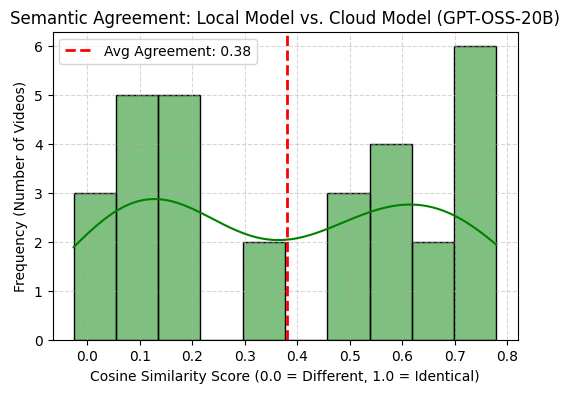

Average Agreement Score: 0.3812
Interpretation: A high score (>0.7) indicates the Local Model captures the same core information as the Cloud Model.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util

# 1. Compute Semantic Similarity between Local and Cloud Summaries
sim_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the summaries generated in Step 5
local_summaries = df_results["Local Model (Flan-T5)"].tolist()
cloud_summaries = df_results["Cloud Model (GPT-OSS-20B)"].tolist()

local_embeddings = sim_model.encode(local_summaries, convert_to_tensor=True)
cloud_embeddings = sim_model.encode(cloud_summaries, convert_to_tensor=True)

# Calculate Cosine Similarity for each video
agreement_scores = []
for i in range(len(local_summaries)):
    score = util.cos_sim(local_embeddings[i], cloud_embeddings[i]).item()
    agreement_scores.append(score)

# Add scores to dataframe for inspection
df_results["Agreement Score"] = agreement_scores

# 2. Visualize the Distribution
plt.figure(figsize=(6, 4))
sns.histplot(agreement_scores, kde=True, color="green", bins=10)

# Add mean line
avg_agreement = np.mean(agreement_scores)
plt.axvline(avg_agreement, color='red', linestyle='--', linewidth=2, label=f'Avg Agreement: {avg_agreement:.2f}')

plt.title('Semantic Agreement: Local Model vs. Cloud Model (GPT-OSS-20B)')
plt.xlabel('Cosine Similarity Score (0.0 = Different, 1.0 = Identical)')
plt.ylabel('Frequency (Number of Videos)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig("benchmark_agreement_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Average Agreement Score: {avg_agreement:.4f}")
print("Interpretation: A high score (>0.7) indicates the Local Model captures the same core information as the Cloud Model.")

## 7. Analysis Conclusion

## Strategic Analysis: The "Efficiency vs. Capability" Trade-off

### 1. Performance Nuance: The Bimodal Reality
Our semantic agreement analysis shows a critical insight that average scores conceal:
* **The "Success" Mode (Cosine ~0.75):** For standard-length videos, the distilled Local Model captures the *exact same* narrative arc as the Cloud Model, proving that 250M parameters are sufficient for core summarization logic.
* **The "Failure" Mode (Cosine < 0.2):** The outliers on the left of the distribution highlight the **Context Window Bottleneck**. The Local Model (Flan-T5) truncates inputs at ~1,024 tokens. If the Cloud Model extracts key insights from the *end* of a long transcript (which the Local Model never saw due to truncation), their summaries diverge completely.

### 2. Qualitative Differences
* **Verbosity:** The Cloud LLM (GPT-OSS-20B) tends to be "chatty," producing smoother, connective prose.
* **Conciseness:** The Local Model (Flan-T5) is strictly utilitarian, producing dense, information-heavy bullet points or short paragraphs. For "information retrieval" use cases, this brevity is often a feature, not a bug.

### 3. Decision Matrix: Local SLM vs. Cloud LLM

| Feature | **Local Model (Flan-T5)** | **Cloud API (OpenRouter/GPT)** | **Winner** |
| :--- | :--- | :--- | :--- |
| **Inference Cost** | **0.00** (Zero Marginal Cost) | **Variable** ($/Million Tokens) | Local |
| **Data Privacy** | **Air-Gapped** (100% Private) | **Third-Party** (Data leaves premise) | Local |
| **Latency** | **Low & Stable** (No network I/O) | **High & Variable** (Network RTT) | Local |
| **Context Window** | **Strict (~1k tokens)** | **Large (4k - 128k tokens)** | Cloud |
| **Coherence** | Functional / Telegraphic | Fluent / Human-like | Cloud |
| **Scalability** | Hardware Bound (Linear) | Elastic (Cloud Autoscaling) | Cloud |

### Conclusion
The Local Model is not a universal replacement for Cloud LLMs. Instead, it is a **specialized, high-efficiency engine** ideal for:
1.  **High-Volume Processing:** Summarizing millions of videos where API costs would be prohibitive.
2.  **Privacy-Sensitive Data:** Internal corporate meetings or personal logs.
3.  **Edge Deployment:** Running on user devices without internet.

For complex, long-form narratives requiring deep synthesis of >30 minutes of content, the Cloud Model remains superior due to its larger context window.